# CompSpec Network trained with Mini-batching

## Intro

* **Date**: 11/26/2020
* **What**: This is the competitive specializing network from [the last experiment](../11_24_2020_experiment_competitive_specializing_network), except trained with mini-batching.
* **Why**: The competitive specializing network blew my expectations out of the water, but it's still about 10x slower than [Krotov's and Hopfield's competitive algo](https://www.pnas.org/content/116/16/7723).  This algorithm converges typically with only one pass through the dataset, whereas Krotov's network takes like 100 passes.  If I can make this as fast as Krotov's network on a single pass through data, then bois, we'd be boolin'.
* **Hopes**: I want this algorithm to train incredibly quickly.  Is that too much to ask for?
* **Limitations**: I super don't know how to do mini-batching correctly.  Luckily, I have Dima's code to work off of, so hopefully it won't be a huge deal.

## Technicals

Basically, everything is the same as the algorithm I ended up with during the last experiment, but now I'm just trying to get it to work with mini-batches.  I'm not going to describe Mini-batching.  If you're reading this, you have an internet connection, so scoot-scoot your lil booty on over to Google and look it up.  It's incredibly straight forward.

## Code

In [192]:
import numpy as np
import matplotlib.pyplot as plt

from time import time
from tensorflow.keras.datasets import mnist
from tqdm import tqdm

L = 28 * 28   #Size of mnist in pixels
S = 60000     #Size of training set

(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X / 255.0

flat_x = np.reshape(train_X, [-1, 1, L])
flat_test = np.reshape(test_X, [-1, 1, L])

In [205]:
def draw_weights(synapses, Kx, Ky):
    yy=0
    HM=np.zeros((28*Ky,28*Kx))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:].reshape(28,28)
            yy += 1
    plt.clf()
    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
    fig.colorbar(im,ticks=[0, np.amax(HM)])
    plt.axis('off')
    fig.canvas.draw()   

In [117]:
def wta_classification(w, T_s):
    flat_x = np.reshape(train_X, [-1, L])
    flat_test = np.reshape(test_X, [-1, L])
    
    v = flat_x[:T_s]
    train_lbls = train_y[:T_s]
    
    v = v / np.array([np.linalg.norm(v, axis=1)]).T
    w = w / np.array([np.linalg.norm(w, axis=1)]).T
    
    wins = np.argmax(w @ (flat_x[:T_s, :]).T, axis=0)
    
    n_wins = np.zeros((w.shape[0], 10))
    
    for (n_i, lbl) in zip(wins, train_lbls):
        n_wins[n_i][lbl] += 1
        
    n_cls = np.argmax(n_wins, axis=1)
    print("Neuron classes:", n_cls)
    
    num_test = test_y.shape[0]
    test_v = flat_test / np.array([np.linalg.norm(flat_test, axis=1)]).T
    
    num_correct = 0
    
    incorrect = np.zeros(10)
    
    for i in range(num_test):
        w_mul_v = w @ test_v[i].T
        
        n_max = np.argmax(w_mul_v)
        
        pre = n_cls[n_max]
        if pre == test_y[i]:
            num_correct += 1
        else:
            incorrect[test_y[i]] += 1
            
    print("Accuracy:", str(num_correct * 100 / num_test) + '%')
    print("Misclassifieds: ", incorrect)
        

In [198]:
"""
flat_x: training data
S: Size of training set
L: Size of input
Kx: Num cols of neurons
Ky: Num rows of neurons
Nep: Num epochs
T_s: Number of training inputs
xi: Base learning constant
phi: Specialization ema constant
B: Batch size

Returns: (synapse_weights, neuron specialization values)
"""
def run_comp_spec_mb(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B):
    start = time()
    N = Kx * Ky
    
    w = np.abs(np.random.normal(0, 1, (N, L))) # synapses of each neuron
    w = w / np.array([np.linalg.norm(w, axis=1)]).T #NORMALIZE THE WEIGHTS TO PREVENT EXXXPLOSIONS
    s = np.zeros(N).reshape(-1, 1) # Specialization for each neuron+

    for ep in range(Nep):
        # Uncomment the following line if you'd like to shuffle the data between epochs
        inputs = flat_x[np.random.permutation(S), :].reshape(S, L)

        for i in tqdm(range(T_s // B)):
            v = inputs[i * B: (i + 1) * B, :]

            w_mul_v = w @ v.T 
            o = w_mul_v / (np.linalg.norm(w, axis=1).reshape(-1, 1) * np.linalg.norm(v, axis=1))

            c = ((1 - s) ** 2) / (1 - o)

            wins = np.argmax(c, axis=0)     

            win_mask = np.zeros((N, B))
            win_mask[wins, np.arange(B)] = 1
            win_mask = (win_mask / np.maximum(np.sum(win_mask, axis=1), 1).reshape(-1, 1))

            win_avg = (np.sum(w_mul_v * win_mask, axis=1)).reshape(-1, 1)

            v_update = win_mask @ v

            del_syn = (v_update - (win_avg * w)) * (((1 - s) ** 2) + 0.1) * xi

            w += del_syn

            s[wins] *= (1 - phi)
            s += phi * np.sum(o * win_mask, axis=1).reshape(-1, 1)

#         draw_weights(w, Kx, Ky)

    print("Max val: ", np.amax(s), "Min value: ", np.amin(s), "Mean val: ", np.mean(s), "Std: ", np.std(s))
    print("Elapsed time: ", time() - start, " seconds")
    
    return (w, s)

## Analysis Dialog

Mother, child, and sister of Thor!  This algorithm is ***SO FAST***.  It's honestly unbelievable.  This is so good I literally just made CodeX private.  HOLY F@#K.

Ok, *\*breath in, breath out*\*.  Basically, I did exactly what I set out to do.  I made yesterday's algorithm like 10x faster using batching.  10 FUCKING TIMES FASTER! HOOOOLLLLYYYY FUCCCCCCCCCKKKKKK!!!!

So yeah, not to totally pat myself on the back, but this algo absolutely *thrashes* Krotov's and Hopfield's network.  

But hey, if there's one thing I learned in English, it's show don't tell.  So, blessed reader (literally probably just future me), watch this mother fucker run.

Let's start with something easy.  100 neurons, 1 epoch, batch size of 100.

100%|██████████| 600/600 [00:00<00:00, 689.89it/s]


Max val:  0.9424756255487233 Min value:  0.6360780334669349 Mean val:  0.8588250078020496 Std:  0.038068598231930546
Elapsed time:  1.0681095123291016  seconds



Neuron classes: [7 2 5 5 7 6 7 0 0 4 9 9 3 1 1 1 1 3 8 5 1 1 7 9 3 7 5 6 0 2 1 9 7 2 0 7 9
 3 2 2 6 4 6 0 7 8 9 8 8 0 3 0 0 7 0 5 3 2 1 0 1 6 4 1 1 0 6 4 1 4 3 8 6 8
 7 3 1 1 6 4 3 9 3 9 3 6 3 6 0 1 9 2 0 5 0 0 1 9 9 9]
Accuracy: 83.75%
Misclassifieds:  [ 23.   9. 200. 176. 322. 235.  65. 172. 282. 141.]


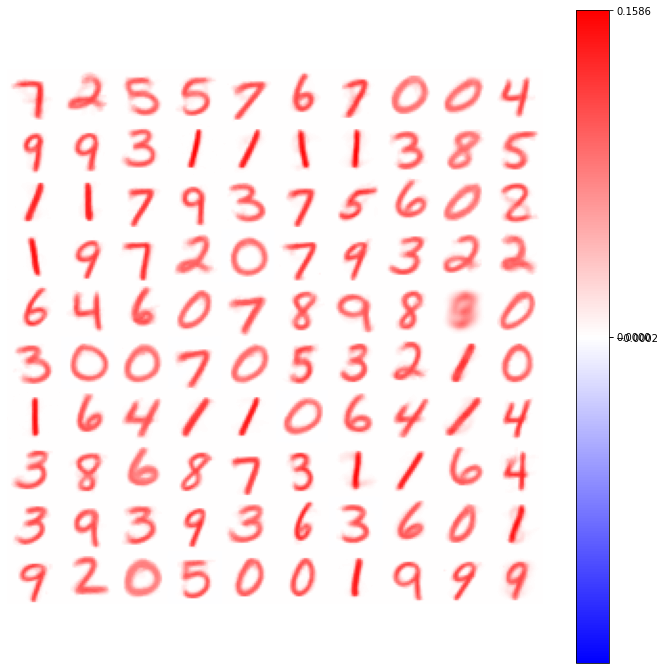

In [199]:
%matplotlib inline
fig=plt.figure(figsize=(12,12))

mu = 0
sig = 1
Kx = 10
Ky = 10
Nep = 1
T_s = 60000
xi = 0.1
theta = 2 / 17
phi = 2 / 11

B = 100 #Batch size

(w, _) = run_comp_spec_mb(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B)
print("\n\n")
wta_classification(w, T_s)
draw_weights(w, Kx, Ky)

I'd like to draw your attention to the progress bar, which keeps track of how long the full loop takes.  THIS ALGO DOESN'T EVEN REGISTER.  Ladies and Gentlemen, this algorithm is running in less than a second.  And what's that?  Oh, yeah...casually is AT DIEHL'S LEVEL.  GET WRECKED DIEHL.  

So yeah, it takes literally a single second to run an entire epoch using batching.  I got to run Krotov's and Hopfield's network to see how long it takes with these parameters.

Ok, I just ran it.  I'm not sure how this is possible, but this algorithm is faster.  The only thing I can possibly think of is the argsort function in their algorithm.  That's got to be it.  

But hey...***THIS ALGORITHM IS LITERALLY EVEN LOOPS THROUGH AN EPOCH FASTER THAN DIMA AND JOHN'S ALGO***.

Oh my gosh it's good.  

Ok. Well, I guess I'll just show you some more runs.

100%|██████████| 300/300 [00:03<00:00, 86.07it/s]


Max val:  0.938816367728712 Min value:  0.6301057730370694 Mean val:  0.8525464364445058 Std:  0.034870130678191905
Elapsed time:  3.695089340209961  seconds



Neuron classes: [1 0 7 2 6 5 2 9 6 4 6 7 3 1 4 7 3 3 5 9 7 2 5 0 1 2 9 3 7 2 6 1 4 3 4 0 5
 6 9 2 5 6 7 4 0 3 9 0 8 2 2 6 6 0 6 0 6 3 6 6 1 0 9 5 7 5 3 9 3 9 6 8 6 5
 9 4 7 7 0 0 1 7 7 4 1 7 9 0 8 2 0 1 8 4 1 5 7 1 7 2 1 1 4 7 5 9 6 6 7 3 9
 5 7 7 3 6 9 1 7 8 1 0 0 5 8 2 1 3 8 2 7 5 6 2 3 0 7 0 3 6 3 6 6 1 7 7 5 9
 6 8 0 0 9 6 3 9 1 9 9 6 3 9 2 1 5 1 1 0 2 5 7 3 2 6 3 7 0 4 9 1 9 0 4 4 0
 0 1 6 5 7 6 0 8 9 3 8 3 6 1 4 5 8 0 7 5 1 8 1 3 3 2 2 6 3 6 3 0 3 2 3 0 8
 2 3 1 7 0 2 3 7 0 2 1 5 4 3 4 9 3 7 0 0 7 6 3 4 6 3 1 5 8 5 0 0 7 9 6 1 0
 0 0 0 8 0 0 3 4 6 0 2 6 0 2 1 4 9 4 3 1 8 4 0 0 2 5 7 4 4 7 4 1 8 6 8 3 3
 7 6 0 8 3 7 2 7 2 6 6 0 7 8 2 4 1 6 9 7 1 5 4 8 9 2 8 8 1 8 8 4 6 0 0 8 8
 0 7 2 9 1 0 9 2 0 6 9 3 3 0 5 5 3 0 3 4 0 6 6 2 1 9 9 2 1 5 8 4 4 9 5 7 9
 0 7 0 0 1 2 3 1 0 9 1 8 9 3 9 3 5 9 7 9 0 3 0 6 9 7 0 4 6 0]
Accuracy: 9

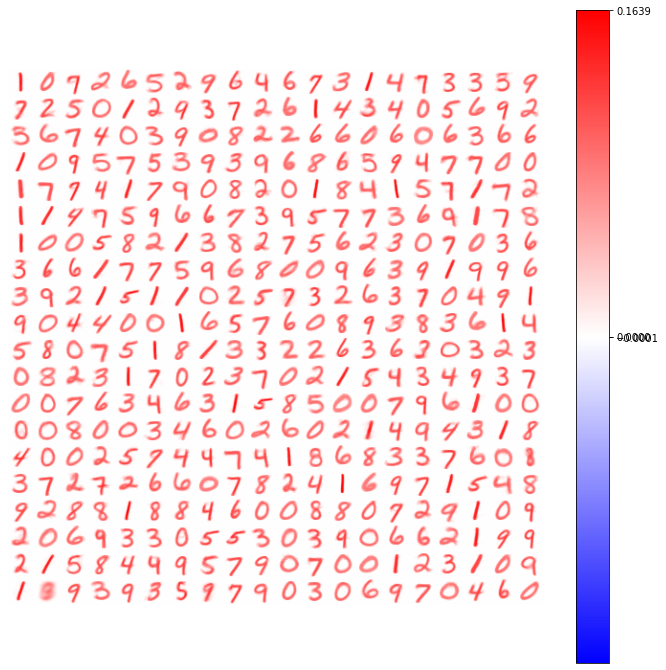

In [202]:
%matplotlib inline
fig=plt.figure(figsize=(12,12))

mu = 0
sig = 1
Kx = 20
Ky = 20
Nep = 1
T_s = 60000
xi = 0.1
theta = 2 / 17
phi = 2 / 11

B = 200 #Batch size

(w, _) = run_comp_spec_mb(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B)
print("\n\n")
wta_classification(w, T_s)
draw_weights(w, Kx, Ky)

Oh, what's that?? Tardy my boots, is this literally doing better than Diehl?  Why yes, yes it is!  Oh, and how long did it train?  4 SECONDS???  Well, I guess it did.  Also notice that fuzzy three lurking at the bottom left.  Lol, can't get me now!  Onward and upward!  

Let's do 1,600!

100%|██████████| 300/300 [00:16<00:00, 18.57it/s]


Max val:  0.8915831718559961 Min value:  0.5868962693632178 Mean val:  0.7331206630874475 Std:  0.045420026049646074
Elapsed time:  16.565123081207275  seconds



Neuron classes: [6 9 0 ... 6 0 6]
Accuracy: 93.2%
Misclassifieds:  [ 15.  12.  56. 103. 101.  78.  31.  96.  94.  94.]


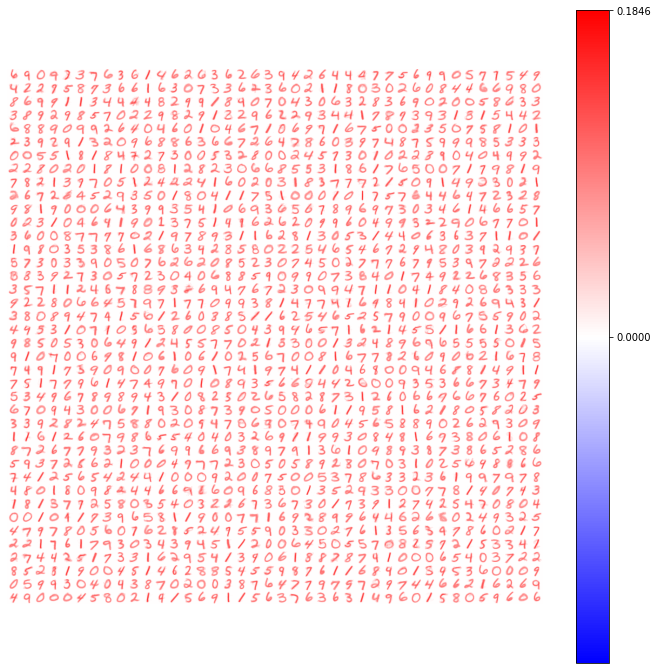

In [206]:
%matplotlib inline
fig=plt.figure(figsize=(12,12))

mu = 0
sig = 1
Kx = 40
Ky = 40
Nep = 1
T_s = 60000
xi = 0.1
theta = 2 / 17
phi = 2 / 11

B = 200 #Batch size

(w, _) = run_comp_spec_mb(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B)
print("\n\n")
wta_classification(w, T_s)
draw_weights(w, Kx, Ky)

Looks like we've beaten Diehl again!  Get absolutely wrecked Diehl!  Ok, let's put the nail in the coffin.  Time for 6,400!

100%|██████████| 300/300 [01:07<00:00,  4.47it/s]


Max val:  0.8154562536084673 Min value:  0.0 Mean val:  0.20434373979108758 Std:  0.2878340818746556
Elapsed time:  67.59501099586487  seconds



Neuron classes: [7 0 0 ... 1 0 0]
Accuracy: 92.98%
Misclassifieds:  [ 14.  13.  69.  75.  99.  84.  22. 103.  98. 125.]


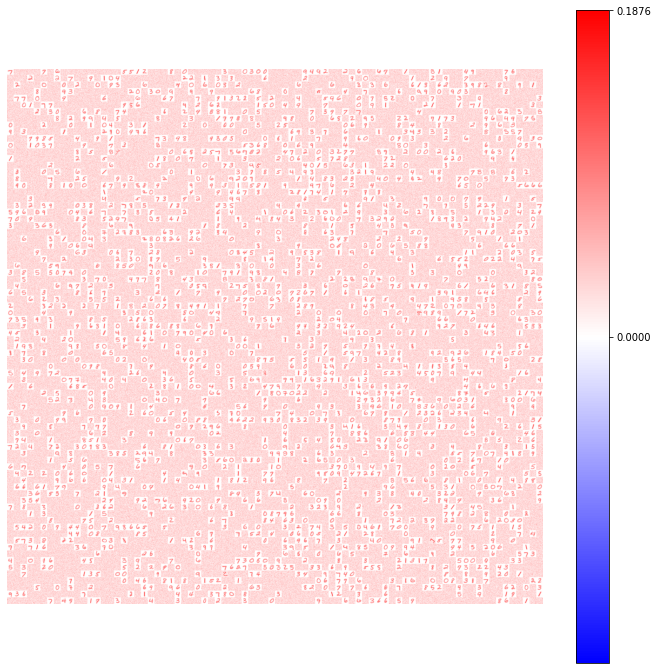

In [207]:
%matplotlib inline
fig=plt.figure(figsize=(12,12))

mu = 0
sig = 1
Kx = 80
Ky = 80
Nep = 1
T_s = 60000
xi = 0.1
theta = 2 / 17
phi = 2 / 11

B = 200 #Batch size

(w, _) = run_comp_spec_mb(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B)
print("\n\n")
wta_classification(w, T_s)
draw_weights(w, Kx, Ky)

Shoot, my arrogance was premature!  I'll let the network train on 5 epochs and see what happens.

100%|██████████| 150/150 [00:48<00:00,  3.15it/s]


Max val:  0.8780144821027273 Min value:  0.0 Mean val:  0.7016918411476376 Std:  0.14384940956186368
Elapsed time:  244.40780234336853  seconds



Neuron classes: [1 0 0 ... 4 3 1]
Accuracy: 94.7%
Misclassifieds:  [11. 17. 44. 59. 81. 71. 24. 71. 81. 71.]


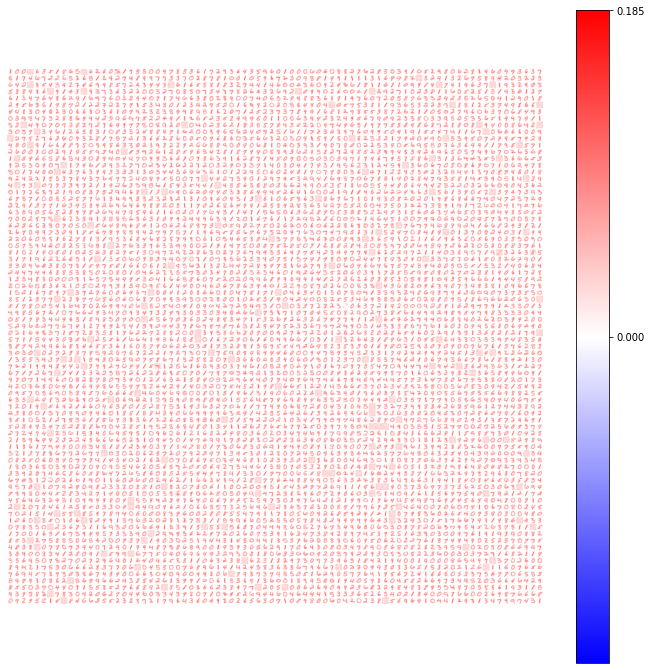

In [208]:
%matplotlib inline
fig=plt.figure(figsize=(12,12))

mu = 0
sig = 1
Kx = 80
Ky = 80
Nep = 5
T_s = 60000
xi = 0.1
theta = 2 / 17
phi = 2 / 11

B = 400 #Batch size

(w, _) = run_comp_spec_mb(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B)
print("\n\n")
wta_classification(w, T_s)
draw_weights(w, Kx, Ky)

There we go.  Now we're getting Diehl-level performance. You'll notice there are a ton of uninitialized inputs, however.  I have a little trick that I think might rectify the situation.  I'm going to bump the batch size down to 100, and bump phi up to 2/3.  I think that might do the trick.  Also I'm going to try one epoch first and see how that goes.

100%|██████████| 600/600 [01:52<00:00,  5.02it/s]


Max val:  0.9324316456698023 Min value:  0.6246714039928134 Mean val:  0.836609497611336 Std:  0.03597954467803136
Elapsed time:  112.59314799308777  seconds



Neuron classes: [1 2 3 ... 1 0 8]
Accuracy: 94.27%
Misclassifieds:  [17. 12. 42. 76. 69. 71. 38. 70. 90. 88.]


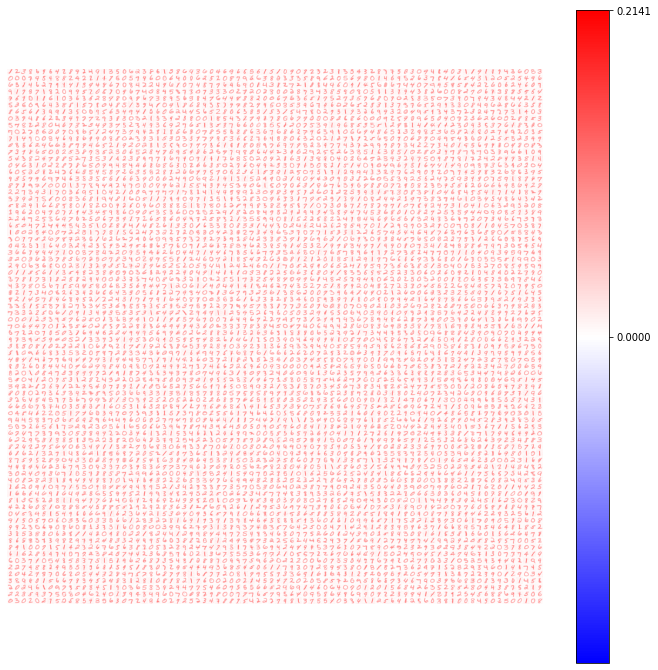

In [209]:
%matplotlib inline
fig=plt.figure(figsize=(12,12))

mu = 0
sig = 1
Kx = 80
Ky = 80
Nep = 1
T_s = 60000
xi = 0.1
theta = 2 / 17
phi = 2 / 3

B = 100 #Batch size

(w, _) = run_comp_spec_mb(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B)
print("\n\n")
wta_classification(w, T_s)
draw_weights(w, Kx, Ky)

Darn.  I was hoping for a bit better.  But that's kinda silly.  Let's do 3 epochs, and I'll bump the batch size up to 400.

100%|██████████| 150/150 [00:51<00:00,  2.87it/s]


Max val:  0.9764919225021953 Min value:  0.6339633279822507 Mean val:  0.8748738376012328 Std:  0.033717423061937195
Elapsed time:  149.92064332962036  seconds



Neuron classes: [0 2 9 ... 9 6 0]
Accuracy: 94.42%
Misclassifieds:  [ 14.  21.  54.  63.  68.  57.  32.  60.  81. 108.]


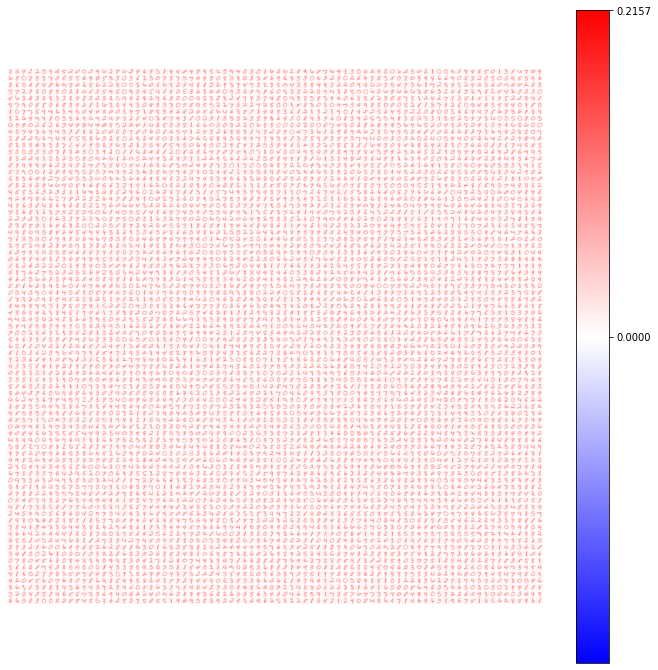

In [210]:
%matplotlib inline
fig=plt.figure(figsize=(12,12))

mu = 0
sig = 1
Kx = 80
Ky = 80
Nep = 3
T_s = 60000
xi = 0.1
theta = 2 / 17
phi = 2 / 3

B = 400 #Batch size

(w, _) = run_comp_spec_mb(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B)
print("\n\n")
wta_classification(w, T_s)
draw_weights(w, Kx, Ky)

Hmph!  You want the big guns? I'll give you the big guns!  Let's do 6 epochs, all parameters still the same, but I'll take the phi down to 2/5.

100%|██████████| 150/150 [00:50<00:00,  3.03it/s]


Max val:  0.9660862067632923 Min value:  0.6305043304800222 Mean val:  0.8887663183520429 Std:  0.02932834700351819
Elapsed time:  298.945054769516  seconds



Neuron classes: [3 8 8 ... 2 0 1]
Accuracy: 94.91%
Misclassifieds:  [15. 12. 42. 67. 67. 52. 19. 62. 80. 93.]


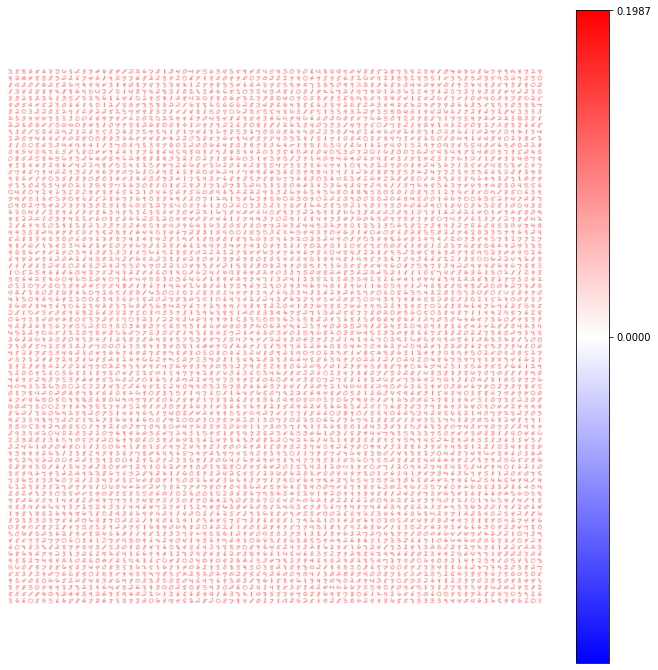

In [211]:
%matplotlib inline
fig=plt.figure(figsize=(12,12))

mu = 0
sig = 1
Kx = 80
Ky = 80
Nep = 6
T_s = 60000
xi = 0.1
phi = 2 / 5

B = 400 #Batch size

(w, _) = run_comp_spec_mb(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B)
print("\n\n")
wta_classification(w, T_s)
draw_weights(w, Kx, Ky)

Blast!  The ol' CompSpec is having a hard time matching Diehl at this number of neurons.  However, Diehl got 95.0%, so I'm only literally 0.1% off.  There can only be so many useful features.  Well, I did what I set out to do.  I think I'm going to close this bad boi out.


## Conclusions

I am a god, and this algorithm is a god.  That's all.  Just kidding.  But like I just said, I did exactly what I wanted to do.  This algorithm works magnificently well.  It's so fast, and it's sooooo efficient.  The only thing that's really lacking is that there's no local repulsion.  I feel like that should be easily rectified.  I can basically just copy what Dima and John did in their network.  

Anyway, this algorithm is fucking fantastic.

## Next Steps

A couple things:

* Local Repulsion: Basically just copy some of Dima's code so that local neurons are repelled away from particular inputs.  That might actually help classification.  We'll see.  


* Overdrive!  While this bad boi is already unreasonably fast, you know what could make it faster?  Fucking GPU!  This seems pretty overkill given how fast the network current is, but it'd be pretty fun.  Also when I finally start using my fucking FPGA, I now have a great algo to implement.


* Classification benchmarks: It's time to hook these feature up to tensorflow and see how it compares to Dima's and John's network.  The super encouraging thing is that I think these features converge faster than a regular ANN trains with backprop, so this algorithm might literally be faster than backprop.  Ok, I just hooked up a simple keras network.  Without GPU, and epoch takes like 20 seconds.  With GPU, and epoch takes 4 seconds.  So this bad boi is still faster.  I wasn't batching, however.  Actually, I just tried batching, and for some reason it doesn't make it any faster.  Gradient descent is a power hungry computation, so my light-weight little boi probably trounces it.  Man I really want to try this algo with tensorflow.

* Cifar 10: I'm itching to try this out on any dataset that is more than stupid handwritten digits.  I'm just kidding mnist.  I love you dearly. But still, colored images would be fucking fantastic.  

Well, that's all I have for right now.  I think I'm going to go right into local repulsion.  Cheers, mate!  Beers all around!!